In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
senti = pd.read_json("../sentiment-analyser/distilbert_s_a_result_14-04-24.json")

In [4]:
senti

,url,pagetitle,text,negative,neutral,positive
0,https://www.mobiliar.ch,Versicherungen & Vorsorge,Versicherungen & Vorsorge,0.230486,0.140164,0.629349
1,https://www.mobiliar.ch/versicherungen-und-vor...,Tierversicherung,Tierversicherung Hunde und Katzen versichern D...,0.458895,0.168780,0.372325
2,https://www.mobiliar.ch/versicherungen-und-vor...,Cyberversicherung,Cyberversicherung Hilfe im digitalen Alltag Ba...,0.431041,0.155108,0.413851
3,https://www.mobiliar.ch/versicherungen-und-vor...,Wohnen & Eigentum,Wohnen & Eigentum,0.208000,0.195661,0.596339
4,https://www.mobiliar.ch/versicherungen-und-vor...,Mietkautionsversicherung,Mietkautionsversicherung Dank einer Mietkautio...,0.338874,0.185144,0.475982
...,...,...,...,...,...,...
1739,https://www.mobiliar.ch/die-mobiliar/ueber-uns...,Wir befähigen für die Zukunft,Wir befähigen für die Zukunft Von der Idee zur...,0.228822,0.119091,0.652087
1740,https://www.mobiliar.ch/die-mobiliar/ueber-uns...,Wir denken Zukunft,Wir denken Zukunft Erfahrungen und Erkenntniss...,0.181774,0.126676,0.691551
1741,https://www.mobiliar.ch/die-mobiliar/ueber-uns...,Leitbild der Gruppe Mobiliar,Leitbild der Gruppe Mobiliar \n\tDas Leitbild...,0.245275,0.097418,0.657307
1742,https://www.mobiliar.ch/die-mobiliar/ueber-uns...,Geisterhaus-Spot gewinnt Silber-Edi.,Geisterhaus-Spot gewinnt Silber-Edi. \n\tAusz...,0.337304,0.129163,0.533533


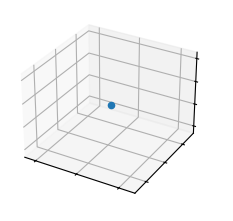

In [6]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('_mpl-gallery')

# Make data
np.random.seed(19680801)
n = 100
rng = np.random.default_rng()
xs = 0.230486	
ys = 0.140164	
zs = rng.uniform(-50, -25, n)

# Plot
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(xs, ys, zs)

ax.set(xticklabels=[],
       yticklabels=[],
       zticklabels=[])

plt.show()

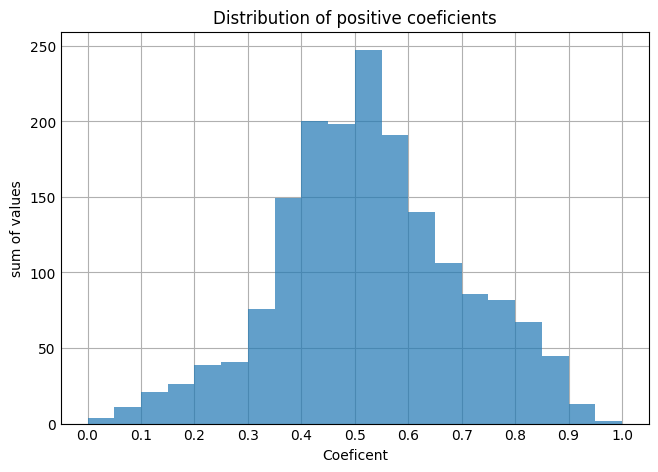

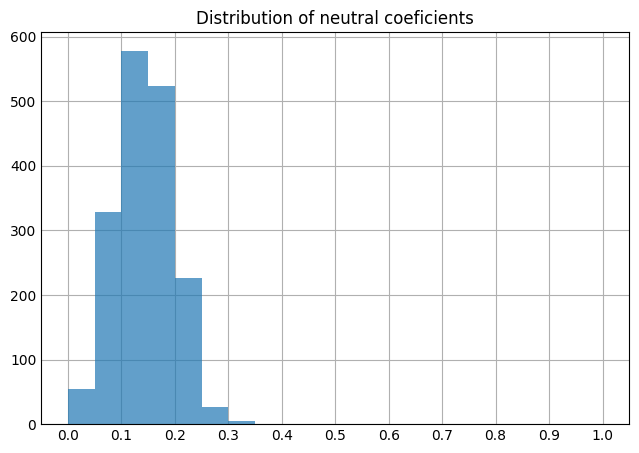

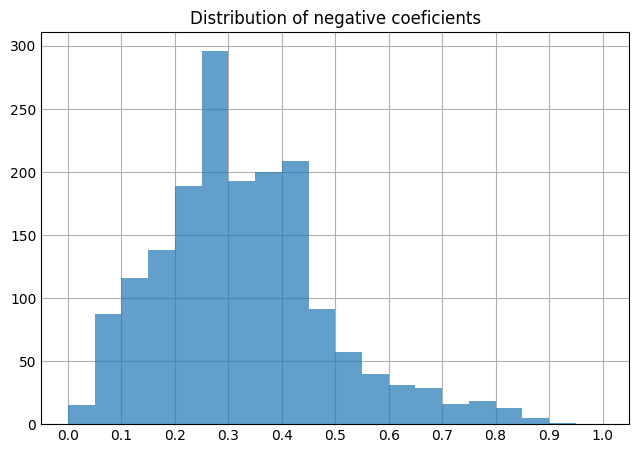

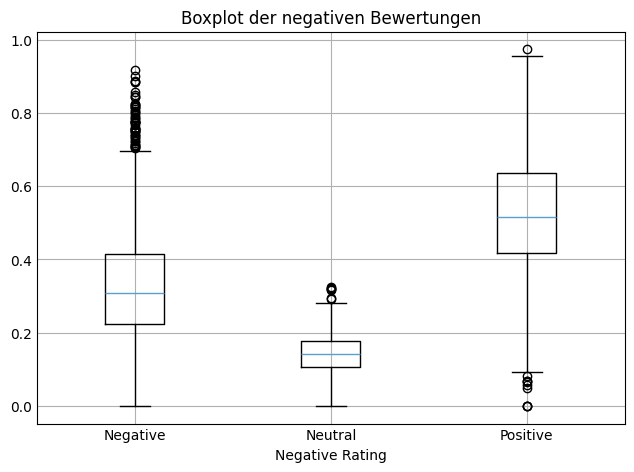

In [21]:
bins = np.arange(0, 1.05, 0.05) 
hist, bin_edges = np.histogram(senti['positive'], bins=bins)

# Histogramm anzeigen
plt.figure(figsize=(6, 4))
plt.bar(bins[:-1], hist, width=0.05, align='edge', alpha=0.7)
plt.xlabel('Coeficent')
plt.ylabel('sum of values')
plt.title('Distribution of positive coeficients')
plt.xticks(np.arange(0, 1.05, 0.1))
plt.grid(True)
plt.show()

hist, bin_edges = np.histogram(senti['neutral'], bins=bins)
plt.figure(figsize=(6, 4))
plt.bar(bins[:-1], hist, width=0.05, align='edge', alpha=0.7)
plt.title('Distribution of neutral coeficients')
plt.xticks(np.arange(0, 1.05, 0.1))
plt.grid(True)
plt.show()

hist, bin_edges = np.histogram(senti['negative'], bins=bins)
plt.figure(figsize=(6, 4))
plt.bar(bins[:-1], hist, width=0.05, align='edge', alpha=0.7)
plt.title('Distribution of negative coeficients')
plt.xticks(np.arange(0, 1.05, 0.1))
plt.grid(True)
plt.show()

# Boxplot erstellen
plt.figure(figsize=(6, 4))
# plt.boxplot(senti['negative'], vert=False)
plt.boxplot([senti['negative'], senti['neutral'], senti['positive']], labels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Negative Rating')
plt.title('Boxplot der negativen Bewertungen')
plt.grid(True)
plt.show()

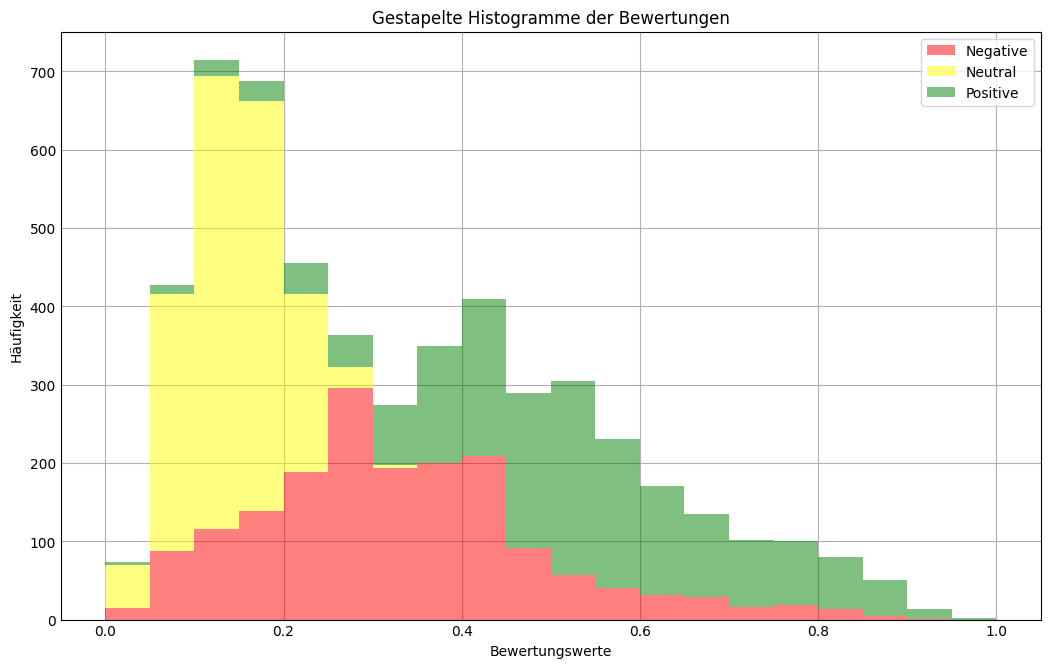

In [20]:
plt.figure(figsize=(10, 6))
plt.hist([senti['negative'], senti['neutral'], senti['positive']], bins=bins, stacked=True, label=['Negative', 'Neutral', 'Positive'], color=['red', 'yellow', 'green'], alpha=0.5)
plt.xlabel('Bewertungswerte')
plt.ylabel('Häufigkeit')
plt.title('Gestapelte Histogramme der Bewertungen')
plt.legend()
plt.grid(True)
plt.show()